<h1>Data Exploration</h1>

In [1]:
import pandas as pd
data = pd.read_json("D:\\Null_class\\Ml\\loan_approval_dataset.json")
excel_file='output.xlsx'
data.to_excel(excel_file, index=False)

data_head=data.head()
summary_stats=data.describe()
missing_values=data.isnull().sum()   #checking null values are present in our data or not.

with open('data_exploration_insights.txt', 'w') as f:
    f.write("Summary Statistics:\n")
    f.write(summary_stats.to_string())
    f.write("\n\nMissing Values:\n")
    f.write(missing_values.to_string())

<h1>Data Visualization</h1>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

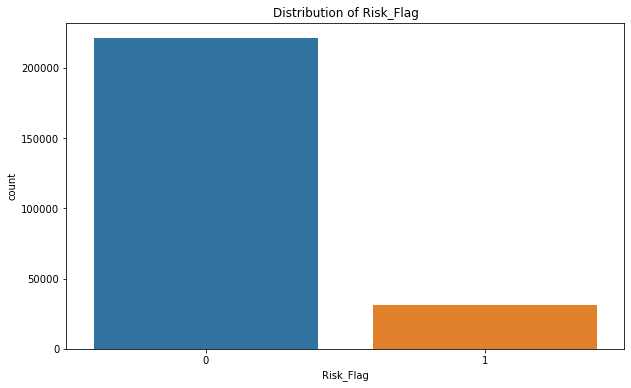

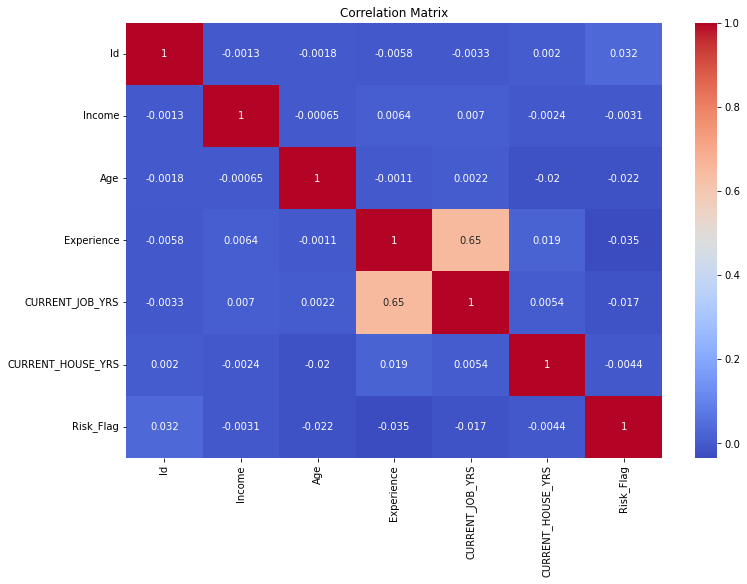

In [3]:
# Data visualization for Risk_Flag distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk_Flag', data=data)
plt.title('Distribution of Risk_Flag')
plt.savefig('risk_flag_distribution.png')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

<h1>Feature Engineering And ModelBuilding</h1>

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_selector as selector

# Splitting the data into training and testing sets
X = data.drop(columns=['Risk_Flag', 'Id'])
y = data['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the preprocessing for numerical and categorical features
numerical_features = selector(dtype_exclude="object")
categorical_features = selector(dtype_include="object")

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Defining the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Training the model
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

print(report)
print(conf_matrix)

# Save the classification report and confusion matrix
with open('model_performance.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(pd.DataFrame(report).to_string())
    f.write("\n\nConfusion Matrix:\n")
    f.write(pd.DataFrame(conf_matrix).to_string())

{'0': {'precision': 0.9358370009606577, 'recall': 0.9476934910974865, 'f1-score': 0.9417279287785796, 'support': 44201}, '1': {'precision': 0.5899982266359284, 'recall': 0.5366994676560736, 'f1-score': 0.5620881905727318, 'support': 6199}, 'accuracy': 0.8971428571428571, 'macro avg': {'precision': 0.762917613798293, 'recall': 0.74219647937678, 'f1-score': 0.7519080596756558, 'support': 50400}, 'weighted avg': {'precision': 0.8933002040948046, 'recall': 0.8971428571428571, 'f1-score': 0.8950337474861579, 'support': 50400}}
[[41889  2312]
 [ 2872  3327]]


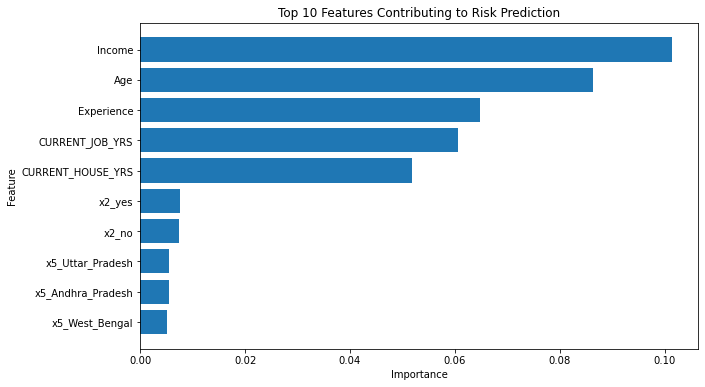

               Feature  Importance
0               Income    0.101295
1                  Age    0.086231
2           Experience    0.064690
3      CURRENT_JOB_YRS    0.060546
4    CURRENT_HOUSE_YRS    0.051778
11              x2_yes    0.007546
10               x2_no    0.007458
405   x5_Uttar_Pradesh    0.005506
380  x5_Andhra_Pradesh    0.005456
408     x5_West_Bengal    0.005162


In [5]:
# Extract feature importances
feature_importances = model.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor
numerical_features = selector(dtype_exclude="object")(X_train)
categorical_features = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out()

# Combine numerical and categorical feature names
feature_names = numerical_features + list(categorical_features)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_features = importance_df.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Contributing to Risk Prediction')
plt.gca().invert_yaxis()
plt.savefig('feature_importances.png')
plt.show()

# Save the feature importances to a CSV file
top_features.to_csv('top_feature_importances.csv', index=False)

print(top_features)

In [6]:
from fpdf import FPDF

class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Loan Risk Prediction Report', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_image(self, image_path, title):
        self.add_page()
        self.chapter_title(title)
        self.image(image_path, w=180)

# Create the PDF report
pdf = PDFReport()

# Add Data Exploration Insights
with open('D:/Null_class/Ml/data_exploration_insights.txt', 'r') as f:
    data_exploration_insights = f.read()

pdf.add_page()
pdf.chapter_title('Data Exploration Insights')
pdf.chapter_body(data_exploration_insights)

# Add Risk_Flag Distribution Image
pdf.add_image('D:/Null_class/Ml/risk_flag_distribution.png', 'Distribution of Risk_Flag')

# Add Correlation Matrix Image
pdf.add_image('D:/Null_class/Ml/correlation_matrix.png', 'Correlation Matrix')

pdf.add_image('feature_importances.png', 'Top 10 Features Contributing to Risk Prediction')

# Add Model Performance
with open('D:/Null_class/Ml/model_performance.txt', 'r') as f:
    model_performance = f.read()

pdf.add_page()
pdf.chapter_title('Model Performance')
pdf.chapter_body(model_performance)

# Save the PDF
pdf.output('D:/Null_class/Ml/loan_risk_prediction_report.pdf')

print("PDF report generated and saved as loan_risk_prediction_report.pdf.")

PDF report generated and saved as loan_risk_prediction_report.pdf.
